In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn import metrics
import torch.nn.functional as F

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# definir os caminhos dos arquivos dos datasets
data_dir = '/content/drive/MyDrive/data/Caes/'
train_dir = os.path.join(data_dir, 'Treino/')
test_dir = os.path.join(data_dir, 'Teste/')

# classes sao os nomes das pastas dentro de cada caminho
classes = ['BulldogFrances', 'Dalmata', 'GoldenRetriver', 'Labrador', 'Pinscher', 'Pug', 'YorkshireTerrier']

In [ ]:
# fazendo as transformações dos arquivos para criação dos datasets
data_transform = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Resize((224,224)),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225]), 
                                    ])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

print('Num imagens de treino: ', len(train_data))
print('Num imagens de teste: ', len(test_data))

Num imagens de treino:  4200
Num imagens de teste:  1400


In [ ]:
# criação dos dataloaders
batch_size = 20
num_workers=0

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

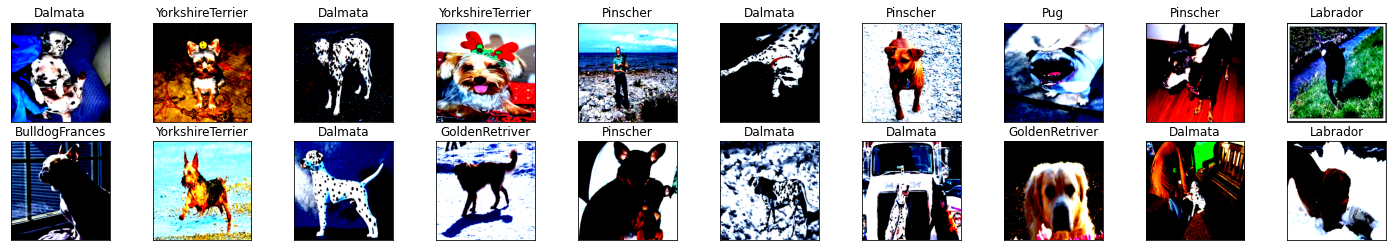

In [ ]:
# Visualização de algumas amostras

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() 
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [ ]:
# definição do modelo
class modelo(nn.Module):
    def __init__(self):
        super(modelo, self).__init__()

        # 6 camadas convulucionais, com relu e normalizacao de batch
        self.conv1 = nn.Sequential(
          nn.Conv2d(3,64,3,1,1),
          nn.ReLU(inplace=True),
          nn.BatchNorm2d(64),
          nn.MaxPool2d(2,2),
          nn.Conv2d(64,128,3,1,1),
          nn.ReLU(inplace=True),
          nn.BatchNorm2d(128),
          nn.MaxPool2d(2,2),
          nn.Conv2d(128,256,3,1,1),
          nn.ReLU(inplace=True),
          nn.Conv2d(256,256,3,1,1),
          nn.ReLU(inplace=True),
          nn.BatchNorm2d(256),
          nn.MaxPool2d(2,2),
          nn.Conv2d(256,512,3,1,1),
          nn.ReLU(inplace=True),
          nn.Conv2d(512,512,3,1,1),
          nn.ReLU(inplace=True),
          nn.BatchNorm2d(512),
          nn.MaxPool2d(2,2)
          )


        self.pool2 = nn.AdaptiveAvgPool2d(output_size=(7, 7))

        # 3 camadas lineares
        self.fc1 = nn.Linear(512 * 7 * 7, len(classes)*1000)
        self.fc2 = nn.Linear(len(classes)*1000, len(classes)*100)
        self.fc3 = nn.Linear(len(classes)*100, len(classes))

        self.dropout = nn.Dropout(0.4)

    def forward(self, x):

        x = self.conv1(x)
        x = self.pool2(x)

        x = x.view(-1, 512 * 7 * 7)

        x = F.relu(self.fc1(x), inplace=True)
        x = self.dropout(x)
        x = F.relu(self.fc2(x), inplace=True)
        x = self.dropout(x)
        x = self.fc3(x)

        return x

model = modelo()
print(model)

modelo(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(256, 512, k

In [ ]:
# verificando disponibilidade do GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    model.cuda()
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# Funçao de perda e optimização
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002)

In [ ]:
# funcao para acuracia
def multi_acc(y_pred, y_test):
    y_log_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_log_softmax, dim = 1)    

    return 100*(y_pred_tags == y_test).float().mean() 

In [ ]:
# treinamento de modelo
def train_model(_model, _optimizer, n_epochs=7):  
  train_acc_min = 0.0
  train_loss_min = np.Inf
  for epoch in range(1, n_epochs+1):
      train_loss = 0.0 
      train_acc = 0.0
      for batch_i, (data, target) in enumerate(train_loader):
          if train_on_gpu:
              data, target = data.cuda(), target.cuda()
          _optimizer.zero_grad()
          output = _model(data)
          loss = criterion(output, target)
          acc = multi_acc(output, target)
          loss.backward()
          _optimizer.step()
          train_loss += loss.item()
          train_acc += acc.item()
          
          
          if train_acc/(batch_i+1) > train_acc_min:
              torch.save(model.state_dict(), 'model_Lucas_CNN.pt')
              train_acc_min = train_acc/(batch_i+1)

          if train_loss/(batch_i+1) < train_loss_min:           
              torch.save(model.state_dict(), 'model_Lucas_CNN.pt')
              train_loss_min = train_loss/(batch_i+1)    

          if batch_i % 20 == 19: 
              print('Epoch %d, Batch %d: loss: %.16f | acc: %.16f' %
                    (epoch, batch_i + 1, train_loss / (batch_i+1), train_acc / (batch_i+1)))
      print('loss: %.16f | acc: %.16f - Modelo Salvo ...' % (train_loss_min, train_acc_min))                   

In [ ]:
train_model(model,optimizer)

Epoch 1, Batch 20: loss: 1.9551286160945893 | acc: 13.7500001430511478
Epoch 1, Batch 40: loss: 1.9245298117399217 | acc: 18.5000003337860122
Epoch 1, Batch 60: loss: 1.8999425113201140 | acc: 21.2500003973642997
Epoch 1, Batch 80: loss: 1.8875773325562477 | acc: 22.9375003457069404
Epoch 1, Batch 100: loss: 1.8700393998622895 | acc: 24.6500004196166991
Epoch 1, Batch 120: loss: 1.8524378081162771 | acc: 26.3750003894170142
Epoch 1, Batch 140: loss: 1.8388083211013249 | acc: 27.0357146944318494
Epoch 1, Batch 160: loss: 1.8287784516811372 | acc: 27.5312504291534417
Epoch 1, Batch 180: loss: 1.8174410210715399 | acc: 27.8055560006035698
Epoch 1, Batch 200: loss: 1.8028379678726196 | acc: 28.5250004291534438
loss: 1.8001370573273072 | acc: 28.5250004291534438 - Modelo Salvo ...
Epoch 2, Batch 20: loss: 1.6160380721092225 | acc: 39.7500003814697251
Epoch 2, Batch 40: loss: 1.6374950379133224 | acc: 37.8750003099441557
Epoch 2, Batch 60: loss: 1.6192378083864847 | acc: 38.5833337306976318


In [ ]:
#Teste de modelo
def evaluate_model(_model):  
  test_loss = 0.0
  class_correct = list(0. for i in range(len(classes)))
  class_total = list(0. for i in range(len(classes)))

  _model.eval() 


  for data, target in test_loader:

      if train_on_gpu:
          data, target = data.cuda(), target.cuda()
      output = _model(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1)    
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
      for i in range(batch_size):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

  test_loss = test_loss/len(test_loader.dataset)
  print('Teste Loss: {:.6f}\n'.format(test_loss))

  for i in range(len(classes)):
      if class_total[i] > 0:
          print('Acuracia de %3s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Acuracia de %5s: N/A (no training examples)' % (classes[i]))

  print('\nAcuracia do teste (Geral): %2d%% (%2d/%2d)' % (
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

In [ ]:
evaluate_model(model)

Teste Loss: 1.342140

Acuracia de BulldogFrances: 36% (72/200)
Acuracia de Dalmata: 66% (133/200)
Acuracia de GoldenRetriver: 66% (133/200)
Acuracia de Labrador: 25% (50/200)
Acuracia de Pinscher: 48% (96/200)
Acuracia de Pug: 50% (101/200)
Acuracia de YorkshireTerrier: 49% (99/200)

Acuracia do teste (Geral): 48% (684/1400)


['BulldogFrances', 'Dalmata', 'GoldenRetriver', 'Labrador', 'Pinscher', 'Pug', 'YorkshireTerrier']


Text(0.5, 69.0, 'Modelo')

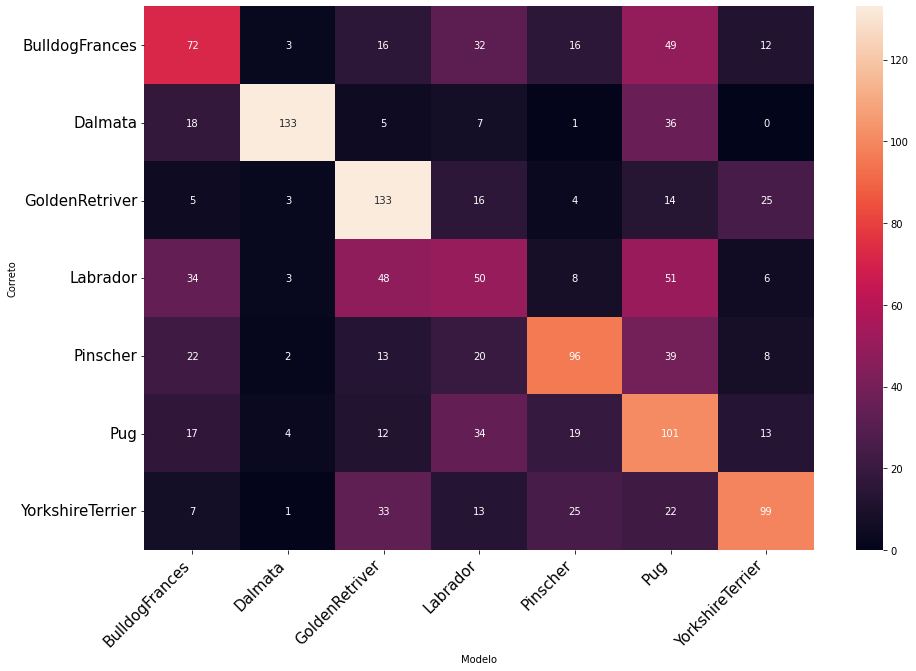

In [ ]:
# Matriz de Confusão
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
nb_classes = len(classes)

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        data = data.to(device)
        target = target.to(device)
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(target.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(15,10))

print(classes)
df_cm = pd.DataFrame(confusion_matrix, index=classes, columns=classes).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('Correto')
plt.xlabel('Modelo')